<a href="https://colab.research.google.com/github/leafprojectean-source/MedicinalLeafClassifierAndIdentifier/blob/main/Leaf_Model%20Using%20VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths
main_dataset_dir = '/content/drive/MyDrive/Medicinal Leaf Dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
augmented_train_dir = 'dataset_vgg/augmented_train'
train_dir = 'dataset_vgg/train'
validation_dir = 'dataset_vgg/validation'

In [4]:
# Create directories if they don't exist
os.makedirs(augmented_train_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [5]:
# List all classes, ignoring hidden files
classes = [d for d in os.listdir(main_dataset_dir) if os.path.isdir(os.path.join(main_dataset_dir, d)) and not d.startswith('.')]

In [6]:
# Data Augmentation for increasing dataset size
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

desired_num_images = 1000  # Total augmented images per class

In [7]:
# Generate augmented images for all classes
for cls in classes:
    class_dir = os.path.join(main_dataset_dir, cls)
    augmented_train_class_dir = os.path.join(augmented_train_dir, cls)
    os.makedirs(augmented_train_class_dir, exist_ok=True)

    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if not images:
        print(f"No images found for class {cls}. Skipping...")
        continue

    # Generate augmented images
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        try:
            img = load_img(img_path, target_size=(128, 128))  # Resize images to 128x128
            x = img_to_array(img).reshape((1,) + img_to_array(img).shape)

            num_augmented_samples = max((desired_num_images - len(images)) // len(images), 0)
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_train_class_dir, save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= num_augmented_samples:
                    break
        except UnidentifiedImageError:
            print(f"Cannot identify image file {img_path}. Skipping...")

    # Ensure original images are copied to the augmented directory
    for img_name in images:
        try:
            shutil.copy(os.path.join(class_dir, img_name), augmented_train_class_dir)
        except Exception as e:
            print(f"Error copying image {img_name}: {e}")

print("Augmented training data generation complete.")

Augmented training data generation complete.


In [8]:
# Split the dataset into training and validation sets
for cls in classes:
    class_augmented_dir = os.path.join(augmented_train_dir, cls)
    class_train_dir = os.path.join(train_dir, cls)
    class_validation_dir = os.path.join(validation_dir, cls)

    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_validation_dir, exist_ok=True)

    images = [f for f in os.listdir(class_augmented_dir) if os.path.isfile(os.path.join(class_augmented_dir, f))]
    if len(images) == 0:
        print(f"No images found in {class_augmented_dir}. Skipping...")
        continue

    # Split data into 80% training and 20% validation
    train_images, validation_images = train_test_split(images, test_size=0.2, random_state=42)

    # Copy images to respective directories
    for img_name in train_images:
        shutil.copy(os.path.join(class_augmented_dir, img_name), os.path.join(class_train_dir, img_name))
    for img_name in validation_images:
        shutil.copy(os.path.join(class_augmented_dir, img_name), os.path.join(class_validation_dir, img_name))

print("Training and validation data split complete.")

Training and validation data split complete.


In [9]:
# Define data generators for training and validation
image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 22294 images belonging to 30 classes.
Found 5588 images belonging to 30 classes.


In [10]:
# Define the VGG-like CNN architecture
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(512, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Number of classes
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


697/697 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - accuracy: 0.1058 - loss: 3.0774 - val_accuracy: 0.4801 - val_loss: 1.6331
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.5267 - loss: 1.5006 - val_accuracy: 0.7142 - val_loss: 0.8606
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 60s 86ms/step - accuracy: 0.7580 - loss: 0.7678 - val_accuracy: 0.8737 - val_loss: 0.3818
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.8695 - loss: 0.4005 - val_accuracy: 0.8998 - val_loss: 0.2848
Epoch 5/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.9097 - loss: 0.2623 - val_accuracy: 0.9204 - val_loss: 0.2503
Epoch 6/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 60s 86ms/step - accuracy: 0.9362 - loss: 0.1865 - val_accuracy: 0.9501 - val_loss: 0.1590
Epoch 7/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.9575 - loss: 0.1180 - val_accuracy: 0.9622 - val_loss: 0.1211
Epoch 8/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.9657 - loss: 0.1014 - val_accura

In [14]:
# Save the model
model.save('leaf_classifier_vgg.h5')
model.save('leaf_classifier_vgg.keras')

In [15]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
train_loss, train_accuracy = model.evaluate(train_generator)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9727 - loss: 0.1057
697/697 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.9950 - loss: 0.0185
Validation Accuracy: 97.07%
Validation Loss: 0.0957
Training Accuracy: 99.54%
Training Loss: 0.0168


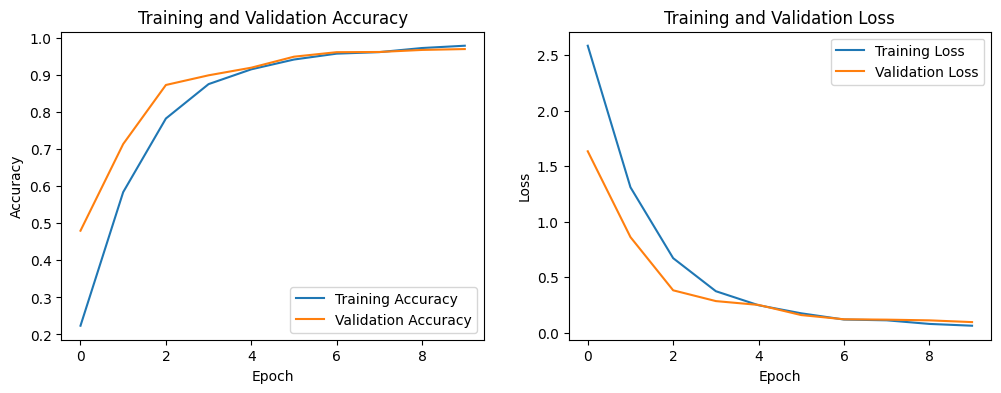

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [17]:
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image
        return img_array
    except UnidentifiedImageError:
        print("Error: The image at the specified path could not be identified.")
        return None

In [18]:
def predict_leaf_name(image_path, model, class_indices):
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        return
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

In [19]:
class_indices = train_generator.class_indices

In [20]:
image_path = '/content/dataset_vgg/validation/Azadirachta Indica (Neem)/AI-S-015.jpg'
predicted_leaf_name = predict_leaf_name(image_path, model, class_indices)
print(f"Predicted Leaf Name: {predicted_leaf_name}")

image_path = '/content/dataset_vgg/validation/Azadirachta Indica (Neem)/AI-S-015.jpg'

# Check if the file exists
if not os.path.exists(image_path):
    print(f"Error: Image file not found at '{image_path}'")
    # You can either exit the program or handle the error appropriately
    # For example, you can try a different image path or skip this image
    # exit()  # Uncomment this line to exit the program if the file is not found

predicted_leaf_name = predict_leaf_name(image_path, model, class_indices)
print(f"Predicted Leaf Name: {predicted_leaf_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Leaf Name: Azadirachta Indica (Neem)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Leaf Name: Azadirachta Indica (Neem)


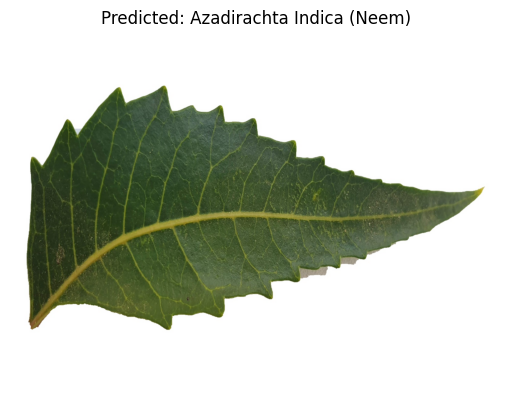

In [21]:
def plot_image_with_prediction(image_path, predicted_label):
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

plot_image_with_prediction(image_path, predicted_leaf_name)

Leaf Predictions

In [22]:
import os
import numpy as np
import pandas as pd
import requests
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError

In [31]:
 df = pd.read_csv('/content/drive/MyDrive/leaf.csv')

In [32]:
print(df.columns)

Index(['plant_name', 'scientific_name', 'features', 'description',
       'MedicinalUses', 'wikipediaLinks'],
      dtype='object')


In [34]:
plant_names = df['plant_name'].values
scientific_names = df['scientific_name'].values
features = df['features'].values
descriptions= df['description'].values
medicinalUses=df['MedicinalUses'].values
wikipediaLinks=df['wikipediaLinks'].values

In [35]:
# Existing dictionaries
class_indices = {name: idx for idx, name in enumerate(plant_names)}
plant_uses = {name: feature for name, feature in zip(plant_names, features)}

# New dictionaries
plant_medicinal_uses = {name: use for name, use in zip(plant_names, medicinalUses)}
plant_wikipedia_links = {name: link for name, link in zip(plant_names, wikipediaLinks)}

In [36]:
image_dir = 'Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
os.makedirs(image_dir, exist_ok=True)

In [37]:
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image
        return img_array
    except UnidentifiedImageError:
        print("Error: The image at the specified path could not be identified.")
        return None

In [38]:
def predict_leaf_name(image_path, model, class_indices):
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        return None, None
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}  # Invert the class indices
    predicted_class_label = class_labels[predicted_class_index]
    predicted_uses = plant_uses.get(predicted_class_label, "No use information available.")
    return predicted_class_label, predicted_uses

In [39]:
def plot_image_with_prediction_and_uses(image_path, predicted_label, uses):
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}\nUses: {uses}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


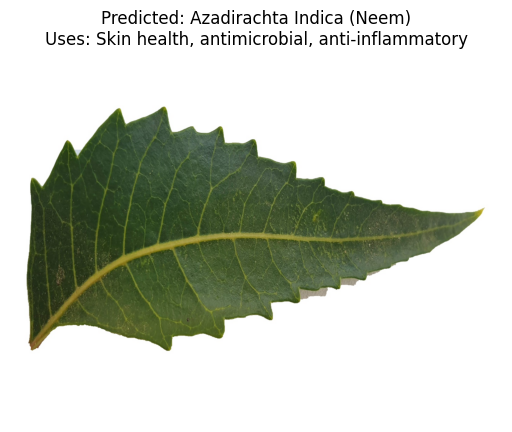

Predicted Plant: Azadirachta Indica (Neem)
Scientific Name: Azadirachta indica
Description: A tree known for its medicinal properties, including antibacterial and antifungal effects; used in skincare and traditional medicine.
Medicinal Uses: Neem leaves are widely used: antimicrobial, antiviral, anti-parasitic, immunomodulatory, anti-inflammatory.
Wikipedia Link: Azadirachta indica – Wikipedia


In [40]:
image_path = '/content/dataset_vgg/validation/Azadirachta Indica (Neem)/AI-S-015.jpg'  # Local image path

predicted_label, predicted_uses = predict_leaf_name(image_path, model, class_indices)

if predicted_label and predicted_uses:
    # Get additional details
    medicinal_use = plant_medicinal_uses.get(predicted_label, "No medicinal info available")
    wiki_link = plant_wikipedia_links.get(predicted_label, "No link available")
    description = {name: desc for name, desc in zip(plant_names, descriptions)}.get(predicted_label, "No description available")
    sci_name = {name: sci for name, sci in zip(plant_names, scientific_names)}.get(predicted_label, "No scientific name available")

    # Plot image + predictions
    plot_image_with_prediction_and_uses(image_path, predicted_label, predicted_uses)

    # Print additional info
    print(f"Predicted Plant: {predicted_label}")
    print(f"Scientific Name: {sci_name}")
    print(f"Description: {description}")
    print(f"Medicinal Uses: {medicinal_use}")
    print(f"Wikipedia Link: {wiki_link}")


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step


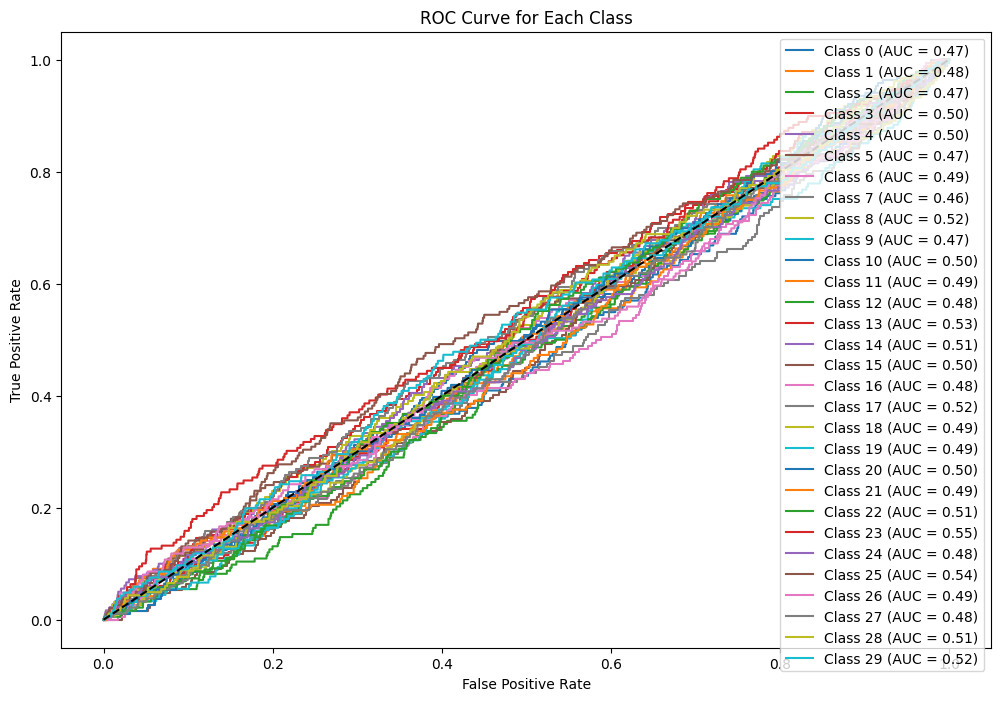

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities
val_labels = val_generator.classes
pred_probs = model.predict(val_generator)
n_classes = pred_probs.shape[1]

# Binarize the true labels for multi-class ROC curve
val_labels_binarized = label_binarize(val_labels, classes=range(n_classes))

# Plotting ROC for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(val_labels_binarized[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

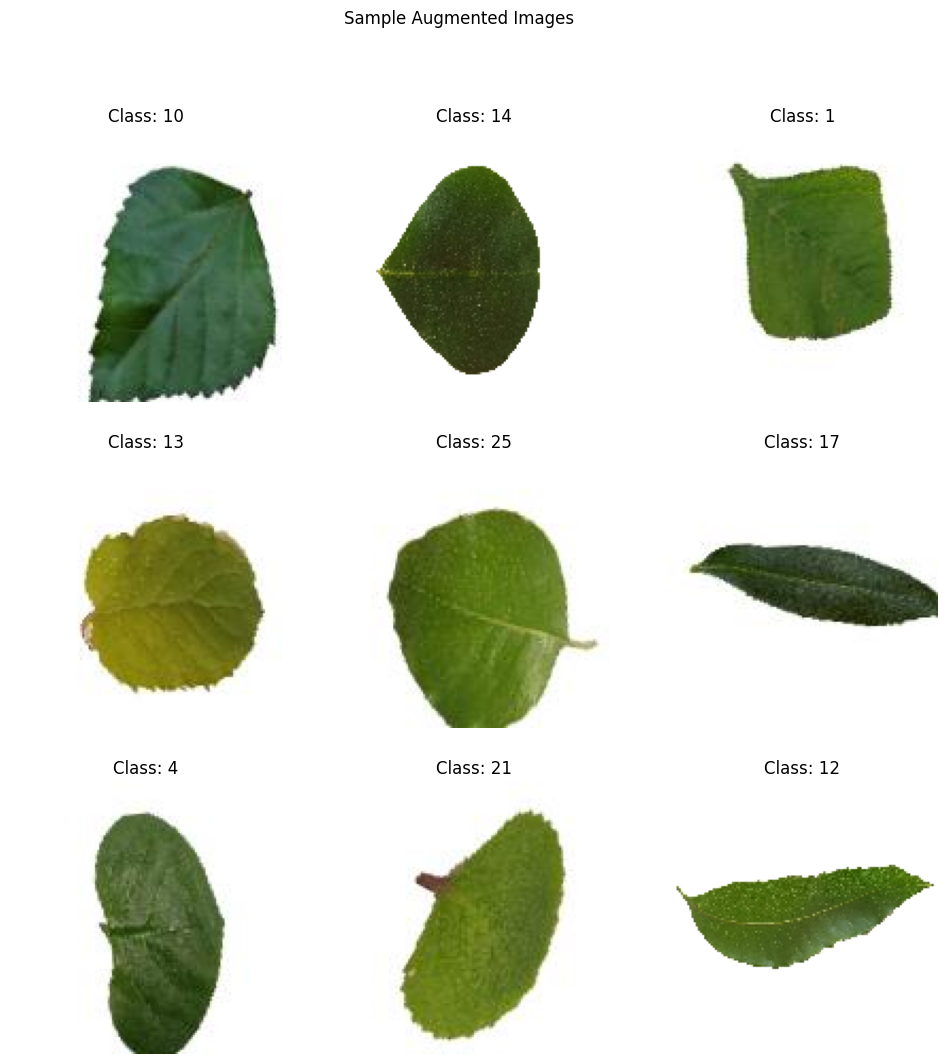

In [42]:
import numpy as np

# Get a batch of augmented images
batch = next(train_generator)
images, labels = batch[0], batch[1]

# Plot a few images
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f'Class: {np.argmax(labels[i])}')
plt.suptitle("Sample Augmented Images")
plt.show()